In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lungvision/resnet.h5
/kaggle/input/lungvision/inception_training.h5
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0629_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0618_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0410_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0462_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-675.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0349_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-556.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-508.png
/kaggle/input/lungvision/dataset/dataset/val/tb/CHNCXR_0646_1.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-684.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-25.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-382.png
/kaggle/input/lungvision/dataset/dataset/val/tb/Tuberculosis-41.png
/kaggle/input/lungvision/dataset/dataset/

## **Tuberculosis (TB) Chest  Prediction**

In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
import shutil

import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3

In [3]:
data_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
labels = ['Tuberculosis', 'Normal']

tuberculosis_count = len(os.listdir(f"{data_path}/{labels[0]}"))
normal_count = len(os.listdir(f"{data_path}/{labels[1]}"))

print(f"Tuberculosis images: {tuberculosis_count}")
print(f"Normal images: {normal_count}")

Tuberculosis images: 700
Normal images: 3500


In [4]:
normal_df = pd.read_excel(f"{data_path}/Normal.metadata.xlsx")

print(normal_df.shape)
normal_df.head()

(3500, 4)


,FILE NAME,FORMAT,SIZE,URL
0,Normal-1,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1,Normal-2,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
2,Normal-3,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3,Normal-4,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
4,Normal-5,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...


In [5]:
tuber_df = pd.read_excel(f"{data_path}/Tuberculosis.metadata.xlsx")

print(tuber_df.shape)
tuber_df.head()

(700, 4)


,FILE NAME,FORMAT,SIZE,URL
0,Tuberculosis-1,PNG,512*512,http://tuberculosis.by/
1,Tuberculosis-2,PNG,512*512,http://tuberculosis.by/
2,Tuberculosis-3,PNG,512*512,http://tuberculosis.by/
3,Tuberculosis-4,PNG,512*512,http://tuberculosis.by/
4,Tuberculosis-5,PNG,512*512,http://tuberculosis.by/


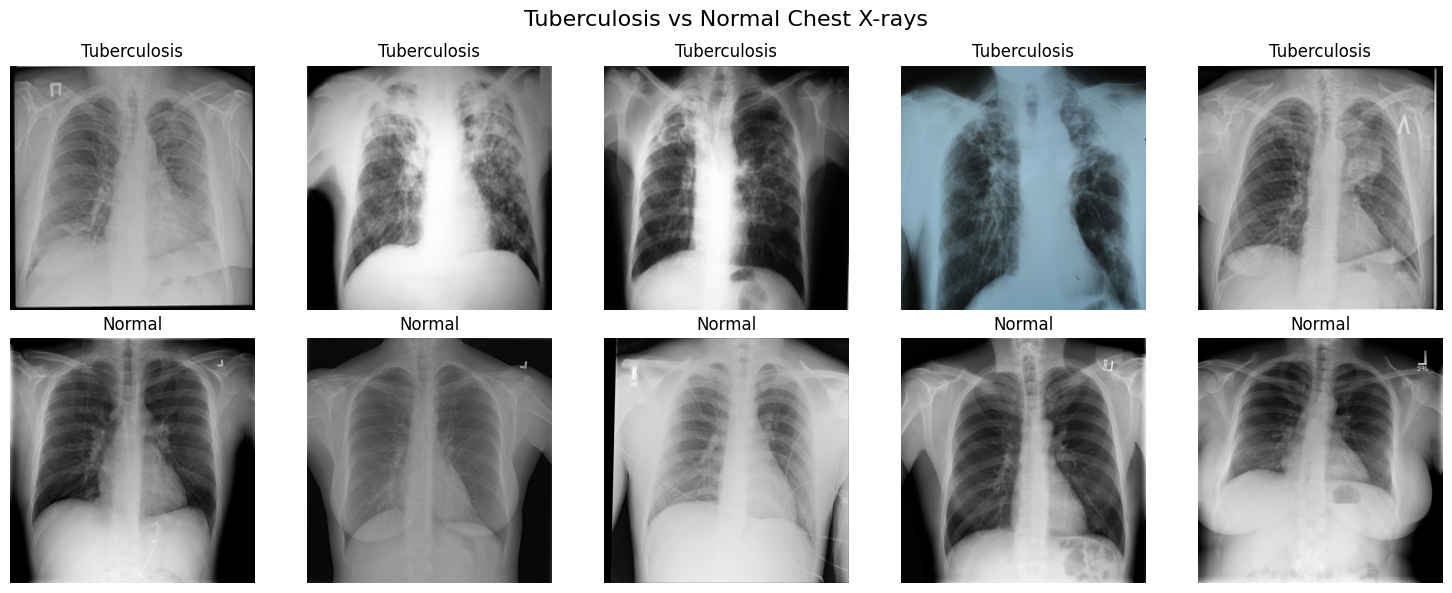

In [6]:
# Function to get 5 sample images from each class
def get_sample_images(label, num_samples=5):
    image_files = os.listdir(os.path.join(data_path, label))[:num_samples]
    image_paths = [os.path.join(data_path, label, img) for img in image_files]
    return image_paths

# Get sample images
tb_images = get_sample_images(labels[0])
normal_images = get_sample_images(labels[1])

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Tuberculosis vs Normal Chest X-rays", fontsize=16)

for i in range(5):
    # Tuberculosis images
    img_tb = Image.open(tb_images[i])
    axes[0, i].imshow(img_tb, cmap='gray')
    axes[0, i].axis("off")
    axes[0, i].set_title("Tuberculosis")

    # Normal images
    img_normal = Image.open(normal_images[i])
    axes[1, i].imshow(img_normal, cmap='gray')
    axes[1, i].axis("off")
    axes[1, i].set_title("Normal")

plt.tight_layout()
plt.show()

## LungVision Tuberculosis Data 

In [7]:
print('Count of Extra TB Images:')
sum((len(os.listdir('/kaggle/input/lungvision/dataset/dataset/train/tb')),
len(os.listdir('/kaggle/input/lungvision/dataset/dataset/test/tb')),
len(os.listdir('/kaggle/input/lungvision/dataset/dataset/val/tb'))))

Count of Extra TB Images:


1094

(503, 512, 3)


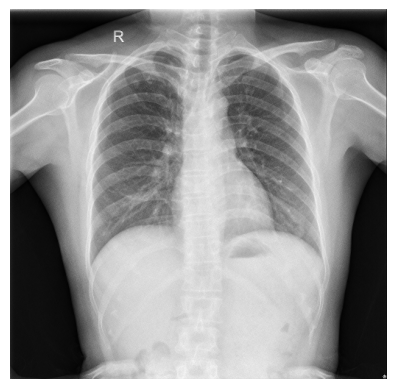

In [8]:
img_tb = Image.open(f'/kaggle/input/lungvision/dataset/dataset/test/tb/CHNCXR_0412_1.png')
print(np.array(img_tb).shape)
plt.imshow(img_tb)
plt.axis('off');

### Handling the extra Tuberculosis images 

In [101]:
shutil.rmtree(image_dir)

In [102]:
# making the desired folders for image arranging 
os.makedirs("/kaggle/working/images", exist_ok = True)
os.makedirs("/kaggle/working/images/Tuberculosis", exist_ok = True)
os.makedirs("/kaggle/working/images/Normal", exist_ok = True)

In [103]:
# function to copy the files to the new image folder 
def copy_files(src_dir, dst_dir):

    # Ensure destination directory exists
    os.makedirs(dst_dir, exist_ok=True)
    
    # Loop through all files in the source directory and copy them
    for file_name in os.listdir(src_dir):
        src_file_path = os.path.join(src_dir, file_name)
        dst_file_path = os.path.join(dst_dir, file_name)  # Default destination path
    
        if os.path.isfile(src_file_path):  # Ensure it's a file
            counter = 1
            while os.path.exists(dst_file_path):  # Rename if file already exists
                name, ext = os.path.splitext(file_name)
                dst_file_path = os.path.join(dst_dir, f"{name}_{counter}{ext}")
                counter += 1
    
            shutil.copy(src_file_path, dst_file_path)  # Copy file to destination

In [104]:
# destination folder path
image_dir = '/kaggle/working/images'

for l in labels:
    src_dir = f"{data_path}/{l}"  # Source folder
    dst_dir = f"{image_dir}/{l}"  # Destination folder
    
    # Copying the images to the new images folder 
    copy_files(src_dir, dst_dir)

In [105]:
extra_tb_paths = ['/kaggle/input/lungvision/dataset/dataset/train/tb',
                  '/kaggle/input/lungvision/dataset/dataset/test/tb', 
                  '/kaggle/input/lungvision/dataset/dataset/val/tb']

dst_dir = f'{image_dir}/{labels[0]}'

for ep in extra_tb_paths:
    copy_files(ep, dst_dir)

In [107]:
print('Tuberculosis images:', len(os.listdir(f'{image_dir}/{labels[0]}')))
print('Normal images:', len(os.listdir(f'{image_dir}/{labels[1]}')))

Tuberculosis images: 1794
Normal images: 3500


In [111]:
# Paths
save_path = "/kaggle/working/aug_images/"
os.makedirs(save_path, exist_ok=True)

target_size = (224, 224)
max_images = 3000  # Total images per class

# Augmentation setup
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Function to count images in a folder
def count_images(folder):
    return len([f for f in os.listdir(folder) if f.endswith(('jpg', 'png', 'jpeg'))]) if os.path.exists(folder) else 0

# Generate images
for label in labels:
    class_path = os.path.join(image_dir, label)  # Original images
    save_class_path = os.path.join(save_path, label)  # Augmented + original images
    os.makedirs(save_class_path, exist_ok=True)

    # Copy original images to the new folder
    original_files = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'png', 'jpeg'))]
    for file in original_files:
        src_path = os.path.join(class_path, file)
        dest_path = os.path.join(save_class_path, file)
        if not os.path.exists(dest_path):  # Avoid duplicate copying
            os.system(f"cp '{src_path}' '{dest_path}'")  # Copies the original images

    existing_count = count_images(save_class_path)  # Count existing images
    print(f"Class: {label} | Existing Images: {existing_count}")

    if existing_count >= max_images:
        # Randomly select images without shuffling the whole list
        selected_images = np.random.choice(original_files, max_images, replace=False)
    
        # Bulk copy using list comprehension (more efficient than a loop)
        _ = [shutil.copy(os.path.join(class_path, img), os.path.join(save_class_path, img)) for img in selected_images]
    
        print(f"Skipping augmentation for {label}, already has {existing_count} images.")
        continue

    # Number of images to generate
    images_needed = max_images - existing_count
    img_index = 0

    # Augment images to balance dataset
    for img_file in original_files:
        if img_index >= images_needed:
            break  # Stop when enough images are generated

        img_path = os.path.join(class_path, img_file)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Create augmented images
        gen = datagen.flow(img_array, batch_size=1)
        for _ in range(10):  # Generate multiple images per original image
            if img_index >= images_needed:
                break
            batch = next(gen)
            aug_img = batch[0] * 255
            aug_img = np.clip(aug_img, 0, 255).astype('uint8')

            # Save augmented image
            aug_img_path = os.path.join(save_class_path, f"{label}_aug_{img_index}.jpg")
            tf.keras.preprocessing.image.save_img(aug_img_path, aug_img)
            img_index += 1

    print(f"Generated {img_index} images for class {label}. Final total: {count_images(save_class_path)}")

Class: Tuberculosis | Existing Images: 1794
Generated 1206 images for class Tuberculosis. Final total: 3000
Class: Normal | Existing Images: 3500
Skipping augmentation for Normal, already has 3500 images.


In [112]:
print("Tuberculosis images Count After Augmentation:", len(os.listdir("/kaggle/working/aug_images/Tuberculosis")))
print("Nomral images Count After Augmentation:", len(os.listdir("/kaggle/working/aug_images/Normal")))

Tuberculosis images Count After Augmentation: 3000
Nomral images Count After Augmentation: 3500


In [123]:
# Define original and target directories
base_dir = data_path
output_dir = "/kaggle/working/splitted_data"  # New directory for the split dataset
categories = labels

# Create directories for train, validation, and test sets
for split in ["train", "val", "test"]:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Function to split and move images
def split_data(category, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)

    # Split data
    train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42)

    # Move files
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, "train", category, file))
    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, "val", category, file))
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(output_dir, "test", category, file))

# Apply the split for both categories
for category in categories:
    split_data(category)

print("✅ Dataset successfully split into train, validation, and test sets!")

✅ Dataset successfully split into train, validation, and test sets!


In [124]:
# Paths
dataset_path = output_dir  # Path to your split dataset
target_size = (224, 224)  # ResNet50 input size
batch_size = 32

# Define ImageDataGenerators with ResNet preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",  # Use "categorical" if more than 2 classes
    shuffle=True
)

# Validation Generator
val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_path, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

# Test Generator (no shuffling for consistency)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

# Print class indices
print("Class Indices:", train_generator.class_indices)

Found 5977 images belonging to 2 classes.
Found 2014 images belonging to 2 classes.
Found 2005 images belonging to 2 classes.
Class Indices: {'Normal': 0, 'Tuberculosis': 1}


In [7]:
# Paths
dataset_path = "/kaggle/working/splitted_data"
target_size = (224, 224)
batch_size = 32

# Define ImageDataGenerators with standard augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Rotate images randomly
    height_shift_range=0.2,  # Shift images vertically
    zoom_range=0.2,  # Randomly zoom into images
    vertical_flip=True 
)

# For validation & test, only rescale (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",  # Use "categorical" if more than 2 classes
    shuffle=True
)

# Validation Generator
val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_path, "val"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

# Test Generator (no shuffling for consistency)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, "test"),
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

# Print class indices
print("Class Indices:", train_generator.class_indices)

Found 2938 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Class Indices: {'Normal': 0, 'Tuberculosis': 1}


In [125]:
# Define class frequencies
freq_pos = tuberculosis_count  # TB images
freq_neg = normal_count  # Normal images

# Compute class weights
pos_weight = freq_neg / freq_pos  # Weight for TB class
neg_weight = freq_pos / freq_neg  # Weight for Normal class

# Convert weights to a tensor for loss function
class_weights = tf.constant([neg_weight, pos_weight], dtype=tf.float32)

def weighted_binary_crossentropy(y_true, y_pred):
    """
    Custom loss function for imbalanced binary classification.
    """
    epsilon = 1e-7  # Avoid log(0)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    loss = -(
        class_weights[1] * y_true * tf.math.log(y_pred) +
        class_weights[0] * (1 - y_true) * tf.math.log(1 - y_pred)
    )
    return tf.reduce_mean(loss)

In [126]:
# Load ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze ALL layers initially
base_model.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(1, activation='sigmoid')(x)  # Binary classification (TB vs. Normal)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), 
              loss=weighted_binary_crossentropy,
              metrics=['accuracy', 'recall', 'precision'])

# model.summary()

In [127]:
# Reduce learning rate when validation loss stops improving
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Fine-tuning training
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks  = [early_stopping, reduce_lr])

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 96s 447ms/step - accuracy: 0.5154 - loss: 2.5729 - precision: 0.4768 - recall: 0.5304 - val_accuracy: 0.7264 - val_loss: 2.5324 - val_precision: 0.9637 - val_recall: 0.4865 - learning_rate: 1.0000e-05
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 75s 389ms/step - accuracy: 0.7494 - loss: 1.3957 - precision: 0.7228 - recall: 0.7545 - val_accuracy: 0.8779 - val_loss: 1.2153 - val_precision: 0.9341 - val_recall: 0.8205 - learning_rate: 1.0000e-05
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 379ms/step - accuracy: 0.8380 - loss: 1.0260 - precision: 0.8172 - recall: 0.8420 - val_accuracy: 0.9091 - val_loss: 0.8238 - val_precision: 0.9269 - val_recall: 0.8938 - learning_rate: 1.0000e-05
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 386ms/step - accuracy: 0.8733 - loss: 0.8100 - precision: 0.8465 - recall: 0.8921 - val_accuracy: 0.9230 - val_loss: 0.6277 - val_precision: 0.9215 - val_recall: 0.9295 - learning_rate: 1.0000e-05
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━

In [121]:
# Load Pre-trained Model (Choose One)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all base model layers
base_model.trainable = False

# Add Custom Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (TB vs. Normal)

# Compile Model
v_model = Model(inputs=base_model.input, outputs=output)
v_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=weighted_binary_crossentropy,
              metrics=['accuracy', 'precision', 'recall'])

# v_model.summary()

In [122]:
# Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "val"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Train Model
v_model.fit(train_generator, validation_data=val_generator, epochs=10)

Found 4176 images belonging to 2 classes.
Found 298 images belonging to 2 classes.
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 327ms/step - accuracy: 0.7527 - loss: 1.6175 - precision: 0.7894 - recall: 0.7208 - val_accuracy: 0.5638 - val_loss: 4.2069 - val_precision: 0.8987 - val_recall: 0.3679
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 243ms/step - accuracy: 0.8914 - loss: 0.8005 - precision: 0.8899 - recall: 0.9068 - val_accuracy: 0.7315 - val_loss: 2.3557 - val_precision: 0.9007 - val_recall: 0.6580
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 0.9010 - loss: 0.5910 - precision: 0.8780 - recall: 0.9430 - val_accuracy: 0.7081 - val_loss: 2.9882 - val_precision: 0.9206 - val_recall: 0.6010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 237ms/step - accuracy: 0.9254 - loss: 0.4682 - precision: 0.9032 - recall: 0.9649 - val_accuracy: 0.6980 - val_loss: 2.9828 - val_precision: 0.9120 - val_recall: 0.5907
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 235ms/step - accuracy

In [120]:
# Evaluate on test data
train_loss, train_acc, train_prec, train_rec = model.evaluate(train_generator)
print(f"Test Accuracy: {train_acc:.4f}\nTest Loss: {train_loss:.4f}\nTest Precision: {train_prec:.4f}\nTest Recall: {train_rec:.4f}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 50s 300ms/step - accuracy: 0.9450 - loss: 0.5185 - precision: 0.9376 - recall: 0.9606
Test Accuracy: 0.9483
Test Loss: 0.4941
Test Precision: 0.9642
Test Recall: 0.9398


In [118]:
# Evaluate on test data
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}\nTest Loss: {test_loss:.4f}\nTest Precision: {test_prec:.4f}\nTest Recall: {test_rec:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 438ms/step - accuracy: 0.9308 - loss: 0.4250 - precision: 0.5812 - recall: 0.6219
Test Accuracy: 0.9463
Test Loss: 0.6029
Test Precision: 0.9564
Test Recall: 0.9604


46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step


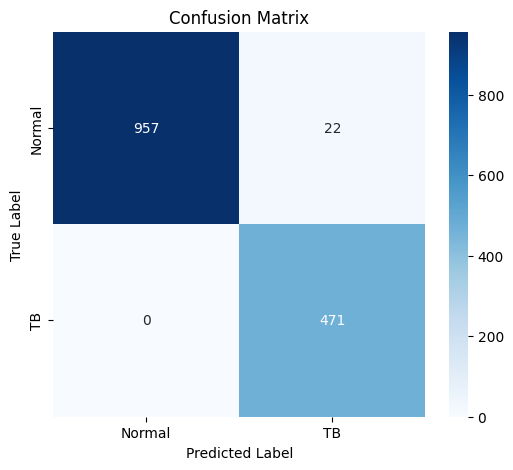

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       979
          TB       0.96      1.00      0.98       471

    accuracy                           0.98      1450
   macro avg       0.98      0.99      0.98      1450
weighted avg       0.99      0.98      0.98      1450



In [17]:
# Get predictions
y_pred_probs = model.predict(test_generator)  # Get probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary (0 or 1)

# Get true labels
y_true = test_generator.classes  # True labels from test data

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "TB"], yticklabels=["Normal", "TB"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print detailed classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "TB"]))

In [37]:
model.save("/kaggle/working/model/resnet_cnn_tb.h5")

In [ ]:
# Function to compute Grad-CAM
def compute_gradcam(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Class of interest (adjust for multi-class)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Function to overlay heatmap on original image
def overlay_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

# Load and preprocess an image
img_path = "/content/TB_web.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Generate Grad-CAM heatmap
heatmap = compute_gradcam(model, img_array, last_conv_layer_name="conv5_block3_out")  # Change layer name as needed

# Overlay heatmap
superimposed_img = overlay_heatmap(img_path, heatmap)

# Show results
plt.imshow(superimposed_img)
plt.axis("off")
plt.show()